# Computer Vision Project (Spitkovska Vladyslava)

In [1]:
!pip install tensorflow torch matplotlib
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os
import re
import copy
import random
from time import time
from collections import Counter, defaultdict
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split, WeightedRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from google.colab import drive
drive.mount('/content/drive')

Device: cuda
Mounted at /content/drive


# Data collecting and short overview

In [4]:
zip_path = "/content/drive/MyDrive/Animals-10.zip"
extract_folder = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


print("Folder structure after extraction:")
for root, dirs, files in os.walk(extract_folder):
    print(root, len(dirs), len(files))

translation_dict = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}


Folder structure after extraction:
/content/dataset 1 1
/content/dataset/raw-img 10 0
/content/dataset/raw-img/cavallo 0 2623
/content/dataset/raw-img/cane 0 4863
/content/dataset/raw-img/scoiattolo 0 1862
/content/dataset/raw-img/ragno 0 4821
/content/dataset/raw-img/elefante 0 1446
/content/dataset/raw-img/mucca 0 1866
/content/dataset/raw-img/farfalla 0 2112
/content/dataset/raw-img/gallina 0 3098
/content/dataset/raw-img/gatto 0 1668
/content/dataset/raw-img/pecora 0 1820


In [5]:
zip_path = "/content/drive/MyDrive/Animals-10.zip"
extract_folder = "/content/dataset"
dataset_path = os.path.join(extract_folder, "raw-img")

In [6]:
num_classes =10

In [7]:
classes = sorted(os.listdir(dataset_path))

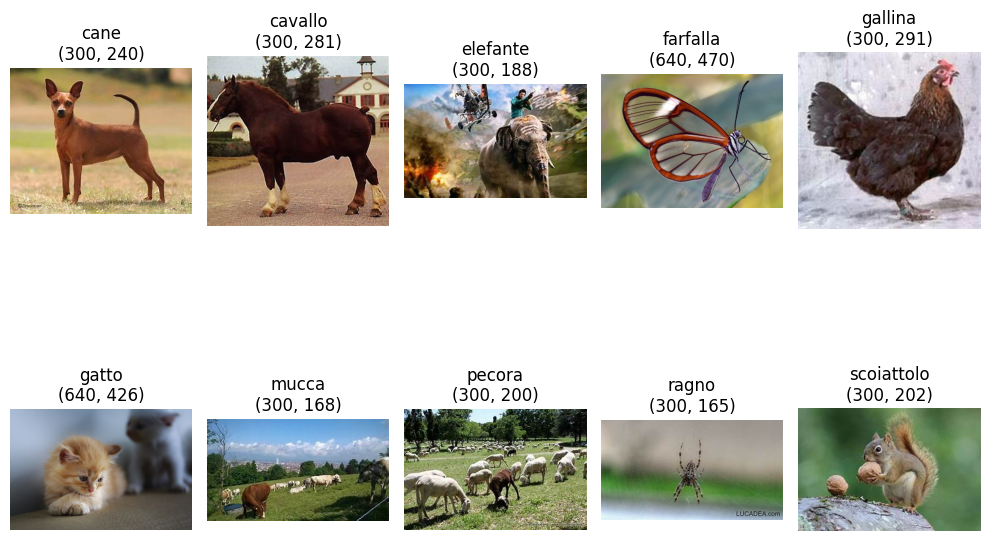

In [ ]:
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    sample_image = random.choice(os.listdir(cls_path))
    image = Image.open(os.path.join(cls_path, sample_image))
    plt.subplot(2, len(classes)//2, i+1)
    plt.imshow(image)
    plt.title(f"{cls}\n{image.size}")
    plt.axis("off")
plt.tight_layout()
plt.show()

A transformation for subsets here:

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [9]:
full_dataset = datasets.ImageFolder(root=dataset_path)

original_classes = full_dataset.classes
translated_classes = [translation_dict.get(cls, cls) for cls in original_classes]
full_dataset.class_to_idx = {translated_classes[i]: v for i, (k, v) in enumerate(full_dataset.class_to_idx.items())}

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_idx, val_idx, test_idx = torch.utils.data.random_split(range(len(full_dataset)), [train_size, val_size, test_size])

Divide dataset into subsets:

In [10]:
# divide into the subsets
train_dataset = Subset(datasets.ImageFolder(dataset_path, transform=train_transform), train_idx)
val_dataset   = Subset(datasets.ImageFolder(dataset_path, transform=val_test_transform), val_idx)
test_dataset  = Subset(datasets.ImageFolder(dataset_path, transform=val_test_transform), test_idx)

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"DataLoader created:")
print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

DataLoader created:
Train set: 18325 images
Validation set: 3926 images
Test set: 3928 images


In [ ]:
image_sizes = []

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    for image_name in os.listdir(cls_path):
        image_full_path = os.path.join(cls_path, image_name)
        try:
            with Image.open(image_full_path) as img:
                image_sizes.append(img.size)
        except Exception as e:
            print(f"Не вдалося відкрити {image_full_path}: {e}")

size_counts = Counter(image_sizes)
print("Частоти різних розмірів зображень:")
for size, count in size_counts.items():
    print(f"Розмір {size}: {count} зображень")


Частоти різних розмірів зображень:
Розмір (227, 300): 20 зображень
Розмір (300, 240): 403 зображень
Розмір (230, 300): 14 зображень
Розмір (300, 200): 3281 зображень
Розмір (300, 300): 1192 зображень
Розмір (300, 225): 4397 зображень
Розмір (300, 249): 68 зображень
Розмір (242, 300): 35 зображень
Розмір (251, 300): 23 зображень
Розмір (300, 236): 58 зображень
Розмір (300, 217): 67 зображень
Розмір (214, 300): 19 зображень
Розмір (269, 300): 20 зображень
Розмір (300, 169): 1048 зображень
Розмір (300, 203): 53 зображень
Розмір (225, 300): 490 зображень
Розмір (300, 206): 109 зображень
Розмір (236, 300): 25 зображень
Розмір (300, 180): 89 зображень
Розмір (200, 300): 362 зображень
Розмір (281, 300): 17 зображень
Розмір (300, 214): 239 зображень
Розмір (300, 235): 104 зображень
Розмір (300, 297): 30 зображень
Розмір (300, 208): 66 зображень
Розмір (300, 207): 99 зображень
Розмір (287, 300): 31 зображень
Розмір (300, 161): 21 зображень
Розмір (300, 233): 95 зображень
Розмір (272, 300): 26 з

In [12]:
def check_image_quality(dataset, num_samples=100):
    plt.close('all')

    brightness_values = []

    for i in range(min(num_samples, len(dataset))):
        img, _ = dataset[i]
        img_np = img.numpy().transpose((1, 2, 0))  # сonvert to numpy
        brightness = np.mean(img_np)  # avg image brightness
        brightness_values.append(brightness)

    plt.figure(figsize=(10, 5))
    plt.hist(brightness_values, bins=20, color='lightcoral', edgecolor='black')
    plt.xlabel('Average brightness')
    plt.ylabel('Number of images')
    plt.title('Histogram of image brightness')
    plt.show()

    print(f"Minimum brightness: {np.min(brightness_values):.3f}")
    print(f"Maximum brightness: {np.max(brightness_values):.3f}")
    print(f"Average brightness: {np.mean(brightness_values):.3f}")

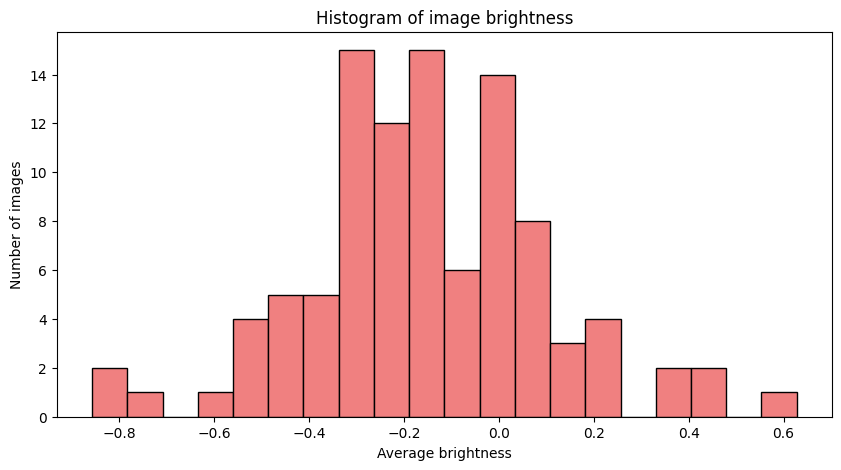

Minimum brightness: -0.858
Maximum brightness: 0.628
Average brightness: -0.149


In [13]:
dataset = datasets.ImageFolder(root=dataset_path, transform=None)

check_image_quality(train_dataset)

In [14]:
def check_class_balance(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    class_names = [classes[idx] for idx in class_counts.keys()]

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Pics quantity')
    plt.title('Class disrbution')
    plt.xticks(rotation=45)
    plt.show()

    print("Pics disctribution per class:")
    for class_name, count in zip(class_names, class_counts.values()):
        print(f"{class_name}: {count} pictures")


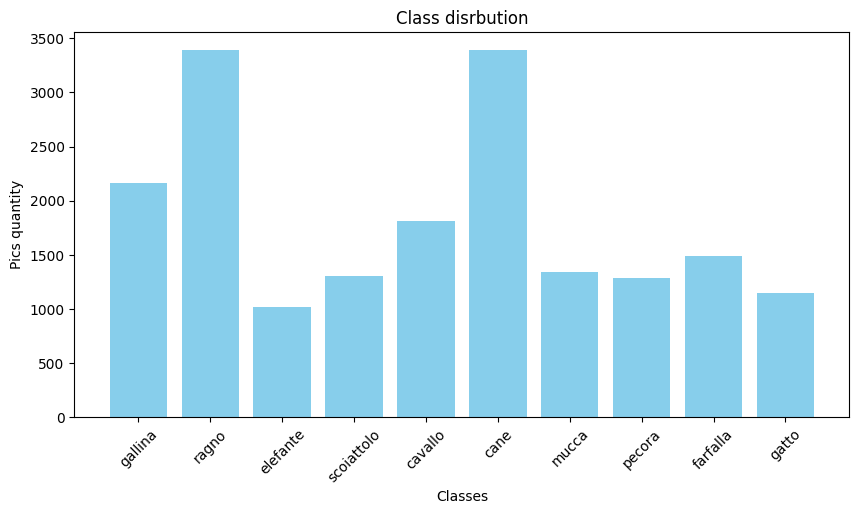

Pics disctribution per class:
gallina: 2166 pictures
ragno: 3389 pictures
elefante: 1018 pictures
scoiattolo: 1301 pictures
cavallo: 1812 pictures
cane: 3389 pictures
mucca: 1336 pictures
pecora: 1285 pictures
farfalla: 1486 pictures
gatto: 1143 pictures


In [15]:
torch.manual_seed(42)
check_class_balance(train_dataset)

Dataset is unbalanced, as we can see from the graph.

# Simple CNN architechture

Let's write down the structure of the model:

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn6(self.conv6(x)))
        x = self.global_pool(x)  #  1x1

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


About the model:

The model uses 3×3 convolutional kernels across all layers to effectively capture local spatial features.
The number of filters increases from 16 to 512, enabling the network to learn hierarchical representations — from simple edges to complex patterns. Each convolution is followed by Batch Normalization, ReLU activation, and Max Pooling to ensure stable training, introduce non-linearity, and reduce spatial dimensions.
The final representation is compressed using Global Average Pooling and passed through fully connected layers with Dropout for robust classification.

# Training and evaluating

In [17]:
model = CNN(10).to(device)
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# Setting the loss function, optimizator, scheduler

> Визначте функцію втрат:


§ Для задачі класифікації виберіть функцію втрат, наприклад,
categorical crossentropy (для багатокласового завдання).


In [18]:
criterion = nn.CrossEntropyLoss()

> Вибір оптимізатора:

§ Виберіть оптимізатор, наприклад, Adam або SGD.

§ Якщо використовуєте Adam, можете налаштувати такі параметри,
як learning rate (наприклад, 0.001).

§ Визначте, чи потрібно застосовувати зменшення learning rate під
час навчання (learning rate scheduling).

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Tried Adam as well. I prefer SGD over it in this particular case.

# Model training

> Налаштуйте параметри тренування:

§ Визначте кількість епох (напр., 20-30) та розмір батча (наприклад,
32 або 64).

§ Незабудьте про використання валідаційного набору для оцінки та
корекції навчання.

Обрала batch_size = 32 для кращої описовості і узагальнення. До того ж, на такій кількості батчів модель тренується без проблем.

> Тренування моделі:

§ Запустіть тренування на підготовленому наборі даних,
перевіряючи метрики, які ви визначили (точність, F1-score та ін.).

§ Після завершення тренування збережіть навчений модель для
подальшого використання.

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_f1 = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(train_acc)

    # ---------- validation ----------
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_losses[-1]:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")


    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved.")

Epoch 1/40: 100%|██████████| 573/573 [00:45<00:00, 12.66it/s]



Epoch 1
Train Loss: 1.9349 | Acc: 0.3193 | F1: 0.1947
Val   Loss: 1.6767 | Acc: 0.4109 | F1: 0.2926
Best model saved.


Epoch 2/40: 100%|██████████| 573/573 [00:44<00:00, 12.80it/s]



Epoch 2
Train Loss: 1.5189 | Acc: 0.4755 | F1: 0.3788
Val   Loss: 1.3628 | Acc: 0.5280 | F1: 0.4388
Best model saved.


Epoch 3/40: 100%|██████████| 573/573 [00:44<00:00, 12.74it/s]



Epoch 3
Train Loss: 1.3170 | Acc: 0.5448 | F1: 0.4739
Val   Loss: 1.2312 | Acc: 0.5774 | F1: 0.5166
Best model saved.


Epoch 4/40: 100%|██████████| 573/573 [00:44<00:00, 12.81it/s]



Epoch 4
Train Loss: 1.2034 | Acc: 0.5880 | F1: 0.5298
Val   Loss: 1.1225 | Acc: 0.6169 | F1: 0.5730
Best model saved.


Epoch 5/40: 100%|██████████| 573/573 [00:44<00:00, 12.84it/s]



Epoch 5
Train Loss: 1.1284 | Acc: 0.6148 | F1: 0.5674
Val   Loss: 1.0971 | Acc: 0.6314 | F1: 0.5736
Best model saved.


Epoch 6/40: 100%|██████████| 573/573 [00:44<00:00, 12.80it/s]



Epoch 6
Train Loss: 1.0555 | Acc: 0.6422 | F1: 0.5992
Val   Loss: 1.0477 | Acc: 0.6386 | F1: 0.5989
Best model saved.


Epoch 7/40: 100%|██████████| 573/573 [00:44<00:00, 12.82it/s]



Epoch 7
Train Loss: 0.9957 | Acc: 0.6615 | F1: 0.6221
Val   Loss: 0.9946 | Acc: 0.6472 | F1: 0.6127
Best model saved.


Epoch 8/40: 100%|██████████| 573/573 [00:44<00:00, 12.76it/s]



Epoch 8
Train Loss: 0.9449 | Acc: 0.6775 | F1: 0.6425
Val   Loss: 0.9566 | Acc: 0.6758 | F1: 0.6303
Best model saved.


Epoch 9/40: 100%|██████████| 573/573 [00:44<00:00, 12.77it/s]



Epoch 9
Train Loss: 0.8979 | Acc: 0.6953 | F1: 0.6620
Val   Loss: 0.9055 | Acc: 0.6959 | F1: 0.6563
Best model saved.


Epoch 10/40: 100%|██████████| 573/573 [00:45<00:00, 12.72it/s]



Epoch 10
Train Loss: 0.8548 | Acc: 0.7101 | F1: 0.6785
Val   Loss: 0.9834 | Acc: 0.6709 | F1: 0.6406


Epoch 11/40: 100%|██████████| 573/573 [00:44<00:00, 12.78it/s]



Epoch 11
Train Loss: 0.8213 | Acc: 0.7222 | F1: 0.6921
Val   Loss: 0.9405 | Acc: 0.6793 | F1: 0.6424


Epoch 12/40: 100%|██████████| 573/573 [00:44<00:00, 12.74it/s]



Epoch 12
Train Loss: 0.7834 | Acc: 0.7341 | F1: 0.7057
Val   Loss: 0.8944 | Acc: 0.6994 | F1: 0.6650
Best model saved.


Epoch 13/40: 100%|██████████| 573/573 [00:44<00:00, 12.80it/s]



Epoch 13
Train Loss: 0.7583 | Acc: 0.7456 | F1: 0.7187
Val   Loss: 0.8414 | Acc: 0.7239 | F1: 0.6863
Best model saved.


Epoch 14/40: 100%|██████████| 573/573 [00:44<00:00, 12.76it/s]



Epoch 14
Train Loss: 0.7186 | Acc: 0.7571 | F1: 0.7312
Val   Loss: 0.8046 | Acc: 0.7292 | F1: 0.7000
Best model saved.


Epoch 15/40: 100%|██████████| 573/573 [00:44<00:00, 12.81it/s]



Epoch 15
Train Loss: 0.6836 | Acc: 0.7686 | F1: 0.7445
Val   Loss: 0.9622 | Acc: 0.6918 | F1: 0.6560


Epoch 16/40: 100%|██████████| 573/573 [00:44<00:00, 12.83it/s]



Epoch 16
Train Loss: 0.6700 | Acc: 0.7746 | F1: 0.7507
Val   Loss: 0.8404 | Acc: 0.7328 | F1: 0.6999


Epoch 17/40: 100%|██████████| 573/573 [00:44<00:00, 12.77it/s]



Epoch 17
Train Loss: 0.6406 | Acc: 0.7822 | F1: 0.7578
Val   Loss: 0.8255 | Acc: 0.7272 | F1: 0.7038
Best model saved.


Epoch 18/40: 100%|██████████| 573/573 [00:44<00:00, 12.79it/s]



Epoch 18
Train Loss: 0.6132 | Acc: 0.7904 | F1: 0.7699
Val   Loss: 0.7849 | Acc: 0.7359 | F1: 0.7057
Best model saved.


Epoch 19/40: 100%|██████████| 573/573 [00:44<00:00, 12.78it/s]



Epoch 19
Train Loss: 0.5844 | Acc: 0.8044 | F1: 0.7855
Val   Loss: 0.8850 | Acc: 0.7185 | F1: 0.6846


Epoch 20/40: 100%|██████████| 573/573 [00:44<00:00, 12.86it/s]



Epoch 20
Train Loss: 0.5560 | Acc: 0.8129 | F1: 0.7941
Val   Loss: 0.9142 | Acc: 0.7091 | F1: 0.6712


Epoch 21/40: 100%|██████████| 573/573 [00:44<00:00, 12.81it/s]



Epoch 21
Train Loss: 0.5484 | Acc: 0.8120 | F1: 0.7927
Val   Loss: 0.7994 | Acc: 0.7374 | F1: 0.7095
Best model saved.


Epoch 22/40: 100%|██████████| 573/573 [00:44<00:00, 12.79it/s]



Epoch 22
Train Loss: 0.5263 | Acc: 0.8199 | F1: 0.8021
Val   Loss: 0.8955 | Acc: 0.7239 | F1: 0.6898


Epoch 23/40: 100%|██████████| 573/573 [00:44<00:00, 12.83it/s]



Epoch 23
Train Loss: 0.4153 | Acc: 0.8643 | F1: 0.8505
Val   Loss: 0.7228 | Acc: 0.7682 | F1: 0.7427
Best model saved.


Epoch 24/40: 100%|██████████| 573/573 [00:45<00:00, 12.73it/s]



Epoch 24
Train Loss: 0.3846 | Acc: 0.8714 | F1: 0.8585
Val   Loss: 0.7314 | Acc: 0.7725 | F1: 0.7456
Best model saved.


Epoch 25/40: 100%|██████████| 573/573 [00:44<00:00, 12.78it/s]



Epoch 25
Train Loss: 0.3672 | Acc: 0.8777 | F1: 0.8652
Val   Loss: 0.7467 | Acc: 0.7697 | F1: 0.7427


Epoch 26/40: 100%|██████████| 573/573 [00:45<00:00, 12.67it/s]



Epoch 26
Train Loss: 0.3593 | Acc: 0.8779 | F1: 0.8648
Val   Loss: 0.7474 | Acc: 0.7733 | F1: 0.7485
Best model saved.


Epoch 27/40: 100%|██████████| 573/573 [00:44<00:00, 12.82it/s]



Epoch 27
Train Loss: 0.3421 | Acc: 0.8864 | F1: 0.8749
Val   Loss: 0.7616 | Acc: 0.7646 | F1: 0.7408


Epoch 28/40: 100%|██████████| 573/573 [00:44<00:00, 12.75it/s]



Epoch 28
Train Loss: 0.3079 | Acc: 0.8971 | F1: 0.8866
Val   Loss: 0.7414 | Acc: 0.7759 | F1: 0.7498
Best model saved.


Epoch 29/40: 100%|██████████| 573/573 [00:44<00:00, 12.78it/s]



Epoch 29
Train Loss: 0.2954 | Acc: 0.9052 | F1: 0.8953
Val   Loss: 0.7267 | Acc: 0.7761 | F1: 0.7500
Best model saved.


Epoch 30/40: 100%|██████████| 573/573 [00:44<00:00, 12.79it/s]



Epoch 30
Train Loss: 0.2898 | Acc: 0.9034 | F1: 0.8932
Val   Loss: 0.7402 | Acc: 0.7774 | F1: 0.7522
Best model saved.


Epoch 31/40: 100%|██████████| 573/573 [00:45<00:00, 12.70it/s]



Epoch 31
Train Loss: 0.2839 | Acc: 0.9107 | F1: 0.9011
Val   Loss: 0.7367 | Acc: 0.7736 | F1: 0.7486


Epoch 32/40: 100%|██████████| 573/573 [00:45<00:00, 12.69it/s]



Epoch 32
Train Loss: 0.2813 | Acc: 0.9084 | F1: 0.8996
Val   Loss: 0.7303 | Acc: 0.7774 | F1: 0.7530
Best model saved.


Epoch 33/40: 100%|██████████| 573/573 [00:45<00:00, 12.69it/s]



Epoch 33
Train Loss: 0.2651 | Acc: 0.9163 | F1: 0.9080
Val   Loss: 0.7378 | Acc: 0.7736 | F1: 0.7507


Epoch 34/40: 100%|██████████| 573/573 [00:44<00:00, 12.79it/s]



Epoch 34
Train Loss: 0.2693 | Acc: 0.9147 | F1: 0.9058
Val   Loss: 0.7339 | Acc: 0.7802 | F1: 0.7546
Best model saved.


Epoch 35/40: 100%|██████████| 573/573 [00:44<00:00, 12.80it/s]



Epoch 35
Train Loss: 0.2699 | Acc: 0.9121 | F1: 0.9024
Val   Loss: 0.7285 | Acc: 0.7822 | F1: 0.7576
Best model saved.


Epoch 36/40: 100%|██████████| 573/573 [00:44<00:00, 12.74it/s]



Epoch 36
Train Loss: 0.2663 | Acc: 0.9156 | F1: 0.9074
Val   Loss: 0.7247 | Acc: 0.7804 | F1: 0.7559


Epoch 37/40: 100%|██████████| 573/573 [00:44<00:00, 12.80it/s]



Epoch 37
Train Loss: 0.2661 | Acc: 0.9138 | F1: 0.9049
Val   Loss: 0.7315 | Acc: 0.7776 | F1: 0.7533


Epoch 38/40: 100%|██████████| 573/573 [00:44<00:00, 12.77it/s]



Epoch 38
Train Loss: 0.2632 | Acc: 0.9147 | F1: 0.9068
Val   Loss: 0.7273 | Acc: 0.7764 | F1: 0.7519


Epoch 39/40: 100%|██████████| 573/573 [00:44<00:00, 12.82it/s]



Epoch 39
Train Loss: 0.2635 | Acc: 0.9151 | F1: 0.9066
Val   Loss: 0.7354 | Acc: 0.7809 | F1: 0.7561


Epoch 40/40: 100%|██████████| 573/573 [00:44<00:00, 12.79it/s]



Epoch 40
Train Loss: 0.2579 | Acc: 0.9179 | F1: 0.9101
Val   Loss: 0.7314 | Acc: 0.7776 | F1: 0.7534


> Візуалізація результатів тренування:

§ Візуалізуйте навчання та валідацію (графіки точності та втрат) за
допомогою matplotlib для аналізу результатів.

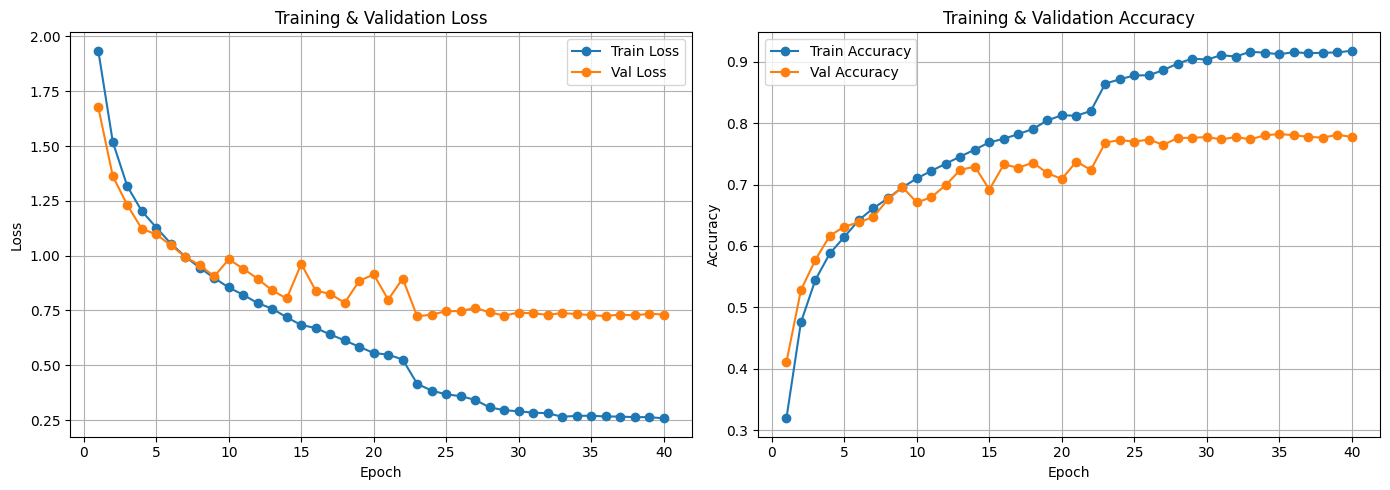

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accs, label="Val Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Validation accuracy graph looks more stable. Moreover, starting from the 10th epoch correlation between either loss and accurracy for both validational and training metrix demonstrates negative correlation type of relations.
Also, after 10th epoch we can see a heteroscedastical tendention between accuracies.
However, eventually we get over 72% of accuracy which increase graph reminds of the root function. At the same time, train loss graph decrease reminds of the offset exponention function.

Let's check how the model recognizes objects with the current accuracy:

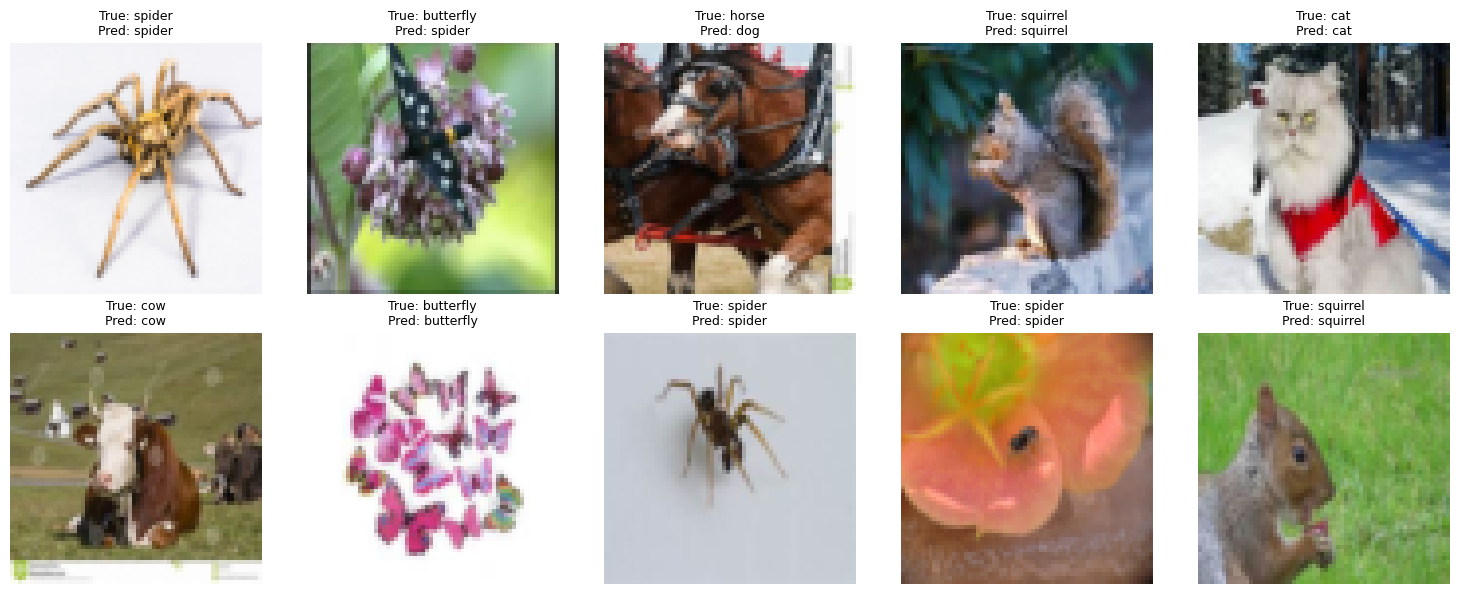

In [ ]:
class_names = translated_classes

model.eval()

all_images = []
all_labels = []
for images, labels in val_loader:
    all_images.append(images)
    all_labels.append(labels)
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

num_samples = 10
total_samples = all_images.size(0)
indices = random.sample(range(total_samples), num_samples)

selected_images = all_images[indices].to(device)
selected_labels = all_labels[indices].to(device)

with torch.no_grad():
    outputs = model(selected_images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 6))
for i in range(num_samples):
    img = selected_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # unnormalize

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[selected_labels[i].item()]}\nPred: {class_names[preds[i].item()]}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


So, the predictive accuracy of the model trained on 40 epochs without implementing early stopping is 78% ~= 80%, as can be observed in the separately displayed case text (8/10).
Early stopping was not used by me in this particular work, because the delta between the validation accuracy values ​​changed in different patterns throughout the training. Is it possible to add an early stop? Yes, but I don't see the point in doing it here right now.
Conclusion: The model recognizes objects well. You can try to improve the accuracy by increasing the number of epochs.

# Hyperparametres tuning

Firslty I will check all the base combinations I could choose and than will use and automative test

In [ ]:
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5, device='cuda'):
    model.to(device)
    train_accs, val_accs = [], []
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(dim=1) == y).sum().item()
            total += y.size(0)
        train_acc = correct / total
        train_accs.append(train_acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(dim=1) == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.3f}, Val Acc = {val_acc:.3f}")

    return train_accs, val_accs

In [ ]:
fc_sizes = [128, 256, 512]
dropout_rates = [0.1, 0.2, 0.305, 0.5]
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]

results = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for fc, dr, lr in product(fc_sizes, dropout_rates, lrs):
    print(f"\nTesting configuration: fc_size={fc}, dropout_rate={dr}, lr={lr}")
    model = MyCNN(num_classes=10, fc_size=fc, dropout_rate=dr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc, val_acc = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=5, device=device)
    results.append((fc, dr, lr, val_acc[-1]))


Testing configuration: fc_size=128, dropout_rate=0.2, lr=0.01
Epoch 1: Train Acc = 0.263, Val Acc = 0.301
Epoch 2: Train Acc = 0.352, Val Acc = 0.424
Epoch 3: Train Acc = 0.453, Val Acc = 0.511
Epoch 4: Train Acc = 0.509, Val Acc = 0.546
Epoch 5: Train Acc = 0.545, Val Acc = 0.592

Testing configuration: fc_size=128, dropout_rate=0.2, lr=0.001
Epoch 1: Train Acc = 0.346, Val Acc = 0.427
Epoch 2: Train Acc = 0.466, Val Acc = 0.512
Epoch 3: Train Acc = 0.513, Val Acc = 0.493
Epoch 4: Train Acc = 0.550, Val Acc = 0.579
Epoch 5: Train Acc = 0.578, Val Acc = 0.586

Testing configuration: fc_size=128, dropout_rate=0.2, lr=0.0001
Epoch 1: Train Acc = 0.257, Val Acc = 0.385
Epoch 2: Train Acc = 0.364, Val Acc = 0.438
Epoch 3: Train Acc = 0.411, Val Acc = 0.471
Epoch 4: Train Acc = 0.446, Val Acc = 0.505
Epoch 5: Train Acc = 0.473, Val Acc = 0.538

Testing configuration: fc_size=128, dropout_rate=0.305, lr=0.01
Epoch 1: Train Acc = 0.269, Val Acc = 0.375
Epoch 2: Train Acc = 0.369, Val Acc = 0


Hyperparameter Tuning Results:
    fc_size  dropout_rate      lr   val_acc
19      512         0.200  0.0010  0.629394
10      256         0.200  0.0010  0.609272
13      256         0.305  0.0010  0.602904
0       128         0.200  0.0100  0.591951
1       128         0.200  0.0010  0.585838
22      512         0.305  0.0010  0.582781
18      512         0.200  0.0100  0.581763
9       256         0.200  0.0100  0.573102
12      256         0.305  0.0100  0.572084
25      512         0.500  0.0010  0.552725
3       128         0.305  0.0100  0.538462
2       128         0.200  0.0001  0.538207
21      512         0.305  0.0100  0.537188
24      512         0.500  0.0100  0.528018
6       128         0.500  0.0100  0.526745
4       128         0.305  0.0010  0.525217
7       128         0.500  0.0010  0.514009
20      512         0.200  0.0001  0.513245
15      256         0.500  0.0100  0.506623
23      512         0.305  0.0001  0.502802
5       128         0.305  0.0001  0.502292


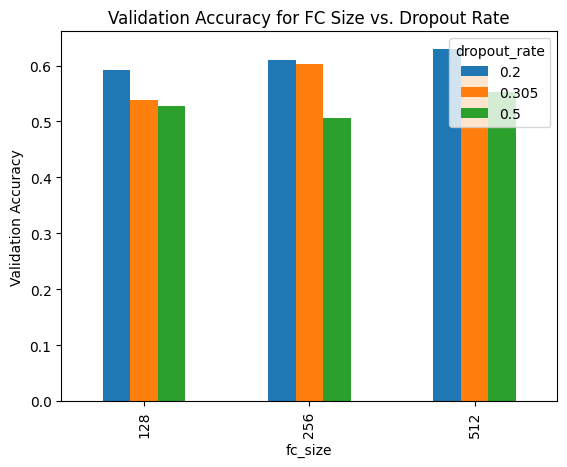

In [ ]:
df = pd.DataFrame(results, columns=["fc_size", "dropout_rate", "lr", "val_acc"])
print("\nHyperparameter Tuning Results:")
print(df.sort_values(by="val_acc", ascending=False))

pivot = df.pivot_table(index="fc_size", columns="dropout_rate", values="val_acc", aggfunc='max')
pivot.plot(kind='bar', title="Validation Accuracy for FC Size vs. Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.show()

# Optuna hyperparametres search

In [20]:
def evaluate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def objective(trial):
    history = {
        'val_acc': [],
        'val_f1': [],
        'val_loss': []
    }

    # hyperparams
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD", "AdamW"])
    momentum = trial.suggest_float("momentum", 0.5, 0.99) if optimizer_name == "SGD" else None

    # model
    model = CNN(num_classes=num_classes).to(device)

    # optimizator
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    EPOCHS = 5
    for epoch in range(EPOCHS):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_acc, val_f1, val_loss = evaluate_metrics(model, val_loader, criterion, device)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_loss'].append(val_loss)

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    trial.set_user_attr("history", history)
    return val_acc

In [21]:
def evaluate_metrics(model, loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1, total_loss / len(loader)

In [22]:
study = optuna.create_study( direction="maximize",sampler=TPESampler(seed=42),pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=2),)

study.optimize(objective, n_trials=60)

print("The best fine-tuned params:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")
print("Best val accuracy:", study.best_value)

[I 2025-04-17 00:05:55,597] A new study created in memory with name: no-name-20623a67-6cdd-4cfb-b34f-04037c7ed959
[I 2025-04-17 00:10:44,370] Trial 0 finished with value: 0.6681100356597045 and parameters: {'lr': 0.0001329291894316216, 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6681100356597045.
[I 2025-04-17 00:15:02,693] Trial 1 finished with value: 0.673713703515028 and parameters: {'lr': 0.0006358358856676254, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.673713703515028.
[I 2025-04-17 00:19:39,740] Trial 2 finished with value: 0.6535914416709119 and parameters: {'lr': 8.17949947521167e-05, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.673713703515028.
[I 2025-04-17 00:24:13,033] Trial 3 finished with value: 0.37111563932755987 and parameters: {'lr': 0.00023345864076016249, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.531875280562787}. Best is trial 1 with value: 0.673713703515028.
[I 2025-04-17 00:2

The best fine-tuned params:
lr: 0.0008306050731972216
batch_size: 32
optimizer: Adam
Best val accuracy: 0.6946001018848701


# Transfer learning & Fine-tuning

I've chosen ResNet as a pretrained model for this part. 2 methods were used so I included both of them in my work.

In [ ]:
model = models.resnet50(pretrained=True)

num_classes = 10

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=15)

Epoch 1: Train Acc = 0.923, Val Acc = 0.970
Epoch 2: Train Acc = 0.954, Val Acc = 0.971
Epoch 3: Train Acc = 0.956, Val Acc = 0.972
Epoch 4: Train Acc = 0.958, Val Acc = 0.968
Epoch 5: Train Acc = 0.957, Val Acc = 0.973
Epoch 6: Train Acc = 0.962, Val Acc = 0.967
Epoch 7: Train Acc = 0.960, Val Acc = 0.966
Epoch 8: Train Acc = 0.961, Val Acc = 0.972
Epoch 9: Train Acc = 0.960, Val Acc = 0.963
Epoch 10: Train Acc = 0.963, Val Acc = 0.974
Epoch 11: Train Acc = 0.964, Val Acc = 0.969
Epoch 12: Train Acc = 0.962, Val Acc = 0.965
Epoch 13: Train Acc = 0.964, Val Acc = 0.972
Epoch 14: Train Acc = 0.966, Val Acc = 0.965
Epoch 15: Train Acc = 0.965, Val Acc = 0.968


([0.9228250191027181,
  0.9543172142779173,
  0.9563912236655387,
  0.9581377578866936,
  0.9574282283593494,
  0.9615762471345923,
  0.9600480296910817,
  0.9611941927737147,
  0.9599934504966706,
  0.962558672633992,
  0.9640323108830914,
  0.9620674598842921,
  0.9640323108830914,
  0.9657788451042463,
  0.9649055779936688],
 [0.9702365810226405,
  0.9707453574154159,
  0.9717629102009667,
  0.968201475451539,
  0.9725260747901298,
  0.9666751462732129,
  0.9664207580768253,
  0.9717629102009667,
  0.9631137115237853,
  0.9735436275756805,
  0.9694734164334775,
  0.9648944288984991,
  0.9715085220045789,
  0.9651488170948868,
  0.968201475451539])

In [ ]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
def train_and_evaluate_mixup(model, optimizer, criterion, train_loader, val_loader, device, epochs=10, alpha=1.0):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha)

            optimizer.zero_grad()
            outputs = model(images)

            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (lam * (predicted == labels_a).sum().item() +
                        (1 - lam) * (predicted == labels_b).sum().item())

        train_acc = correct / total
        avg_train_loss = running_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.3f}, Val Acc = {val_acc:.3f}")

    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accuracies, val_accuracies)


In [ ]:
model, metrics = train_and_evaluate_mixup(
    model, optimizer, criterion,
    train_loader, val_loader,
    device=device,
    epochs=10,
    alpha=1.0
)

Epoch 1: Train Acc = 0.682, Val Acc = 0.948
Epoch 2: Train Acc = 0.703, Val Acc = 0.936
Epoch 3: Train Acc = 0.701, Val Acc = 0.940
Epoch 4: Train Acc = 0.709, Val Acc = 0.959
Epoch 5: Train Acc = 0.713, Val Acc = 0.952
Epoch 6: Train Acc = 0.707, Val Acc = 0.958
Epoch 7: Train Acc = 0.716, Val Acc = 0.957
Epoch 8: Train Acc = 0.707, Val Acc = 0.965
Epoch 9: Train Acc = 0.714, Val Acc = 0.955
Epoch 10: Train Acc = 0.718, Val Acc = 0.930


In [ ]:
torch.save(model.state_dict(), 'mixup_model_best.pth')

In [ ]:
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [ ]:
true_labels, pred_labels = get_all_preds(model, val_loader, device)

In [ ]:
print(classification_report(true_labels, pred_labels, digits=4))

              precision    recall  f1-score   support

           0     0.9712    0.9558    0.9634       317
           1     0.9834    0.9442    0.9634       251
           2     0.9955    0.9548    0.9748       465
           3     0.9952    0.7393    0.8484       280
           4     0.9545    0.9781    0.9662       730
           5     0.9766    0.9631    0.9698       217
           6     0.9404    0.9619    0.9511       394
           7     0.7959    0.9853    0.8805       273
           8     0.9586    0.9903    0.9742       724
           9     0.9890    0.9643    0.9765       280

    accuracy                         0.9537      3931
   macro avg     0.9560    0.9437    0.9468      3931
weighted avg     0.9574    0.9537    0.9533      3931



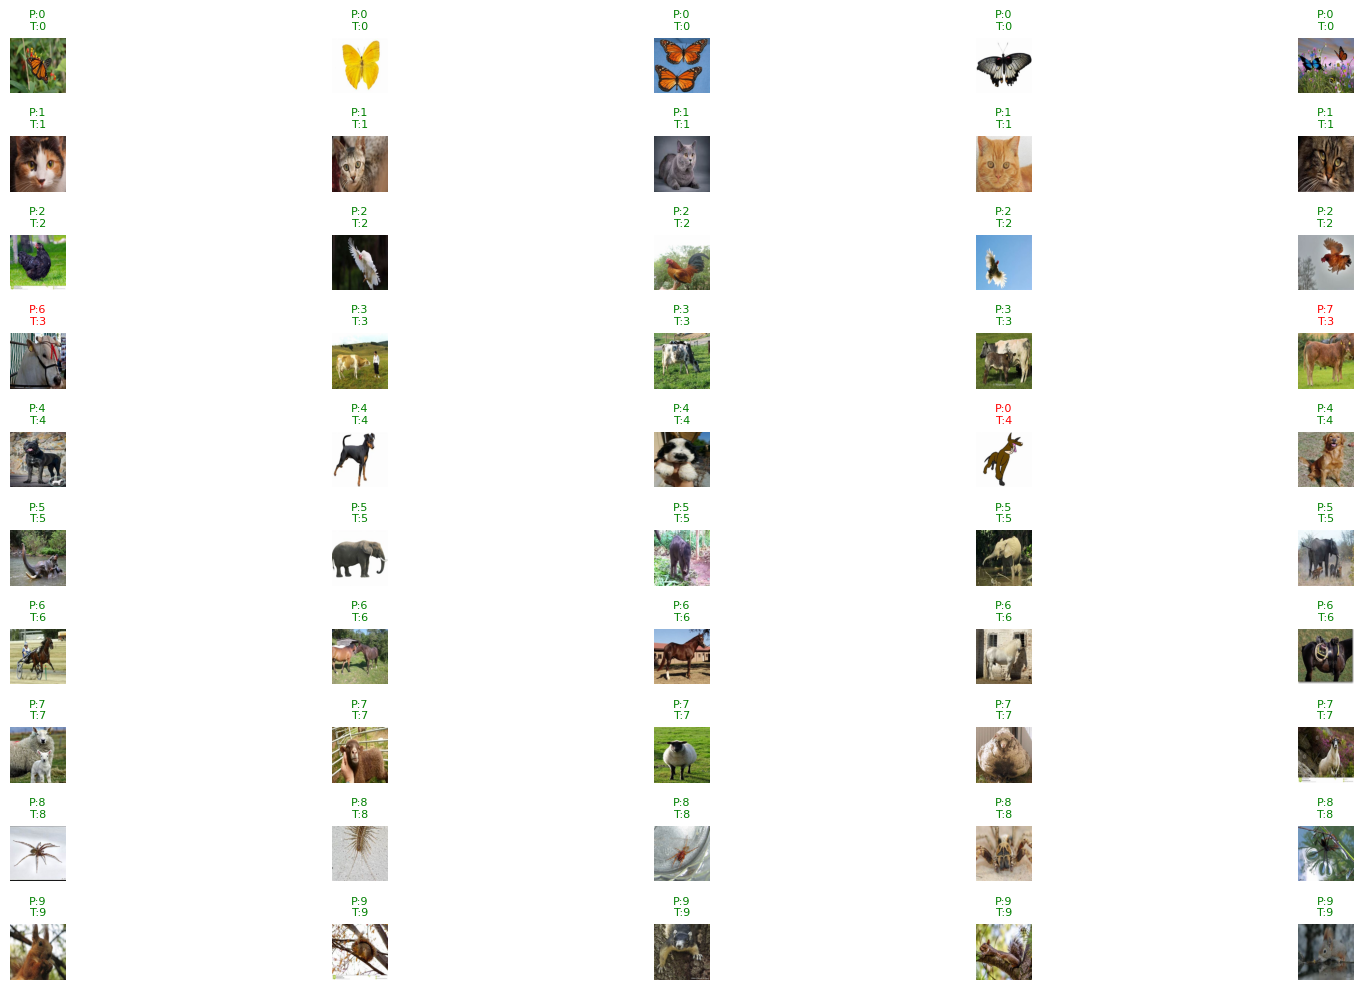

In [ ]:
def vis_pred_per_class(model, dataloader, class_names, samples_per_class=5):
    model.eval()
    collected_by_class = defaultdict(list)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(inputs, preds, labels):
                cls = label.item()
                if len(collected_by_class[cls]) < samples_per_class:
                    collected_by_class[cls].append((img.cpu(), pred.item(), label.item()))
            if all(len(collected_by_class[cls]) >= samples_per_class for cls in range(len(class_names))):
                break

    total = samples_per_class * len(class_names)
    plt.figure(figsize=(18, 10))
    index = 1
    for cls in range(len(class_names)):
        for img, pred, label in collected_by_class[cls]:
            plt.subplot(len(class_names), samples_per_class, index)
            plt.axis('off')
            plt.imshow(denormalize(img, mean, std).permute(1, 2, 0).numpy())

            title_color = "green" if pred == label else "red"
            plt.title(f"P:{class_names[pred]}\nT:{class_names[label]}", fontsize=8, color=title_color)
            index += 1

    plt.tight_layout()
    plt.show()

vis_pred_per_class(model, val_loader, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Acc: 0.9483
F1: 0.9480


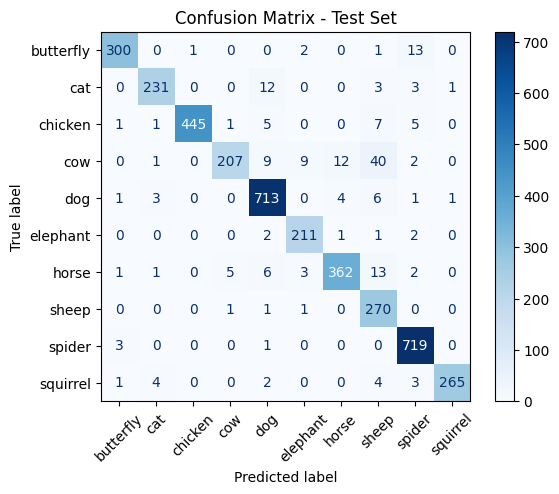

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Acc: {test_acc:.4f}")
print(f"F1: {test_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

# ResNet train without custom CNN

In [ ]:
# resnet model build
base_model = ResNet50V2(include_top=False, input_shape=(256,256,3), weights='imagenet')
# freeze base model
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
], name="ResNet50V2_FT")

# kомпіліруємо модель для початкової фази (Phase 1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print("Model Summary (Phase 1 - Frozen Base, Weak Augmentation):")
model.summary()

In [ ]:
# callbacks
checkpoint_dir = os.path.join("Models", model.name)
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                             monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
callbacks_list = [earlystop, checkpoint, reduce_lr]

Model Summary (Phase 1 - Frozen Base, Weak Augmentation):


Model: "ResNet50V2_FT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,092,938 (91.91 MB)

 Trainable params: 527,626 (2.01 MB)

 Non-trainable params: 23,565,312 (89.89 MB)


=== Phase 1: Weak Augmentation (Epochs 1-5) ===
Epoch 1/5
    573/Unknown 131s 210ms/step - accuracy: 0.8815 - loss: 0.7975
Epoch 1: val_accuracy improved from -inf to 0.95644, saving model to Models/ResNet50V2_FT/best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 158s 256ms/step - accuracy: 0.8816 - loss: 0.7971 - val_accuracy: 0.9564 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 2/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9547 - loss: 0.4132
Epoch 2: val_accuracy improved from 0.95644 to 0.96612, saving model to Models/ResNet50V2_FT/best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9547 - loss: 0.4132 - val_accuracy: 0.9661 - val_loss: 0.3141 - learning_rate: 0.0010
Epoch 3/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9561 - loss: 0.3302
Epoch 3: val_accuracy did not improve from 0.96612
573/573 ━━━━━━━━━━━━━━━━━━━━ 134s 234ms/step - accuracy: 0.9561 - loss: 0.3302 - val_accuracy: 0.9656 - val_loss: 0.2838 - learning_rate: 0.001

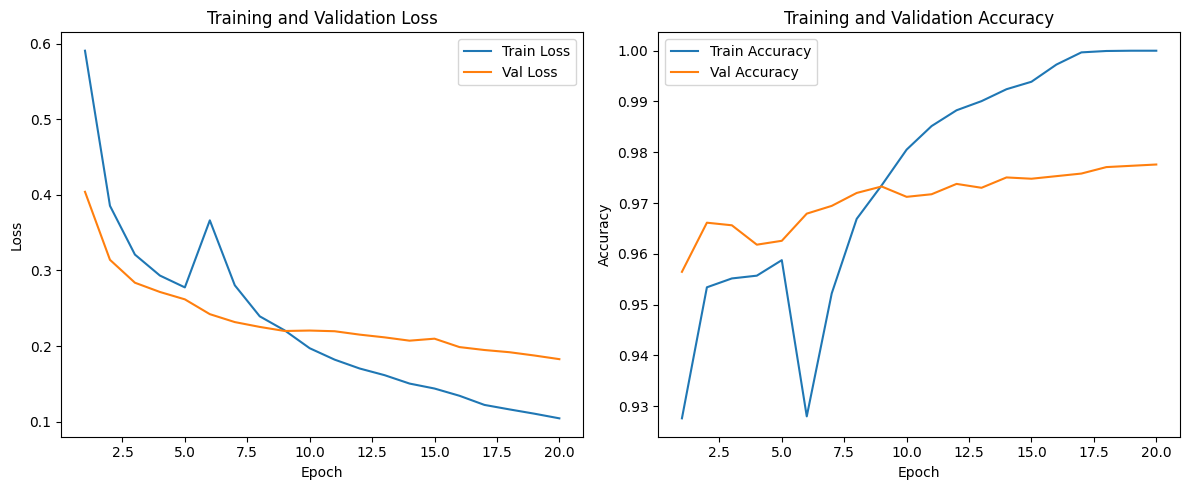



Evaluating model on test dataset...
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.9734 - loss: 0.1996
Test Loss: 0.2082, Test Accuracy: 0.9733


In [ ]:
# training
#phase 2 : low augmentation
print("\n=== Phase 1: Weak Augmentation (Epochs 1-5) ===")
history_phase1 = model.fit(
    tf_train_ds,
    validation_data=tf_val_ds,
    epochs=5,
    callbacks=callbacks_list,
    verbose=1
)

# weights
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in targets]

#phase 2 : high augmentation
train_dataset.dataset.transform = strong_train_transform
tf_train_ds = create_tf_dataset(train_dataset)

# leave layers before fine_tune_at
# unfreezing some layers
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print("\n=== Phase 2: Strong Augmentation & Fine-tuning (Epochs 6-15) ===")
history_phase2 = model.fit(
    tf_train_ds,
    validation_data=tf_val_ds,
    epochs=10,
    callbacks=callbacks_list,
    verbose=1
)

# phase 3 : no augmentation
train_dataset.dataset.transform = noaug_train_transform
tf_train_ds = create_tf_dataset(train_dataset)

print("\n=== Phase 3: No Augmentation & Continued Fine-tuning (Epochs 16-20) ===")
history_phase3 = model.fit(
    tf_train_ds,
    validation_data=tf_val_ds,
    epochs=5,
    callbacks=callbacks_list,
    verbose=1
)

# graph cunstruction
def merge_history(hist1, hist2, hist3):
    merged = {}
    for key in hist1.history.keys():
        merged[key] = hist1.history[key] + hist2.history[key] + hist3.history[key]
    return merged

merged_history = merge_history(history_phase1, history_phase2, history_phase3)

def plot_graphs(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\n\nPlotting Training History...")
plot_graphs(merged_history)

print("\n\nEvaluating model on test dataset...")
test_loss, test_acc = model.evaluate(create_tf_dataset(test_dataset), verbose=1)
print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(test_loss, test_acc))

In [ ]:
model.save(os.path.join(checkpoint_dir, "final_model.keras"))

We could try to increase epochs to 40 to get better accuracy. As we already saw, heteroscedasticity still works for us.
In thje further steps, I will try to update my model with some new decisions to increase the accuracy even more.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━

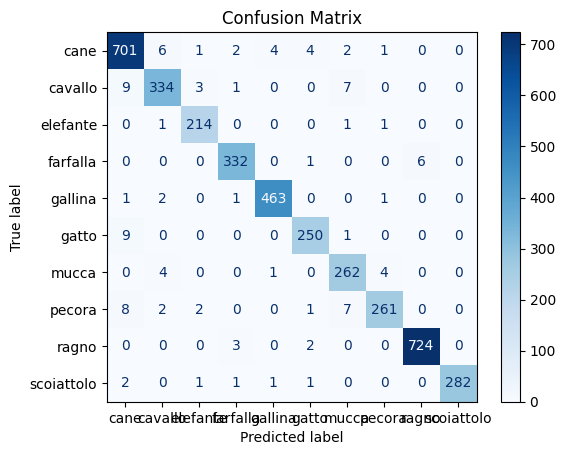

In [ ]:
y_pred = []
y_true = []

for images, labels in tf_test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

show_conf_matrix(model, test_loader, translated_classes, device)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


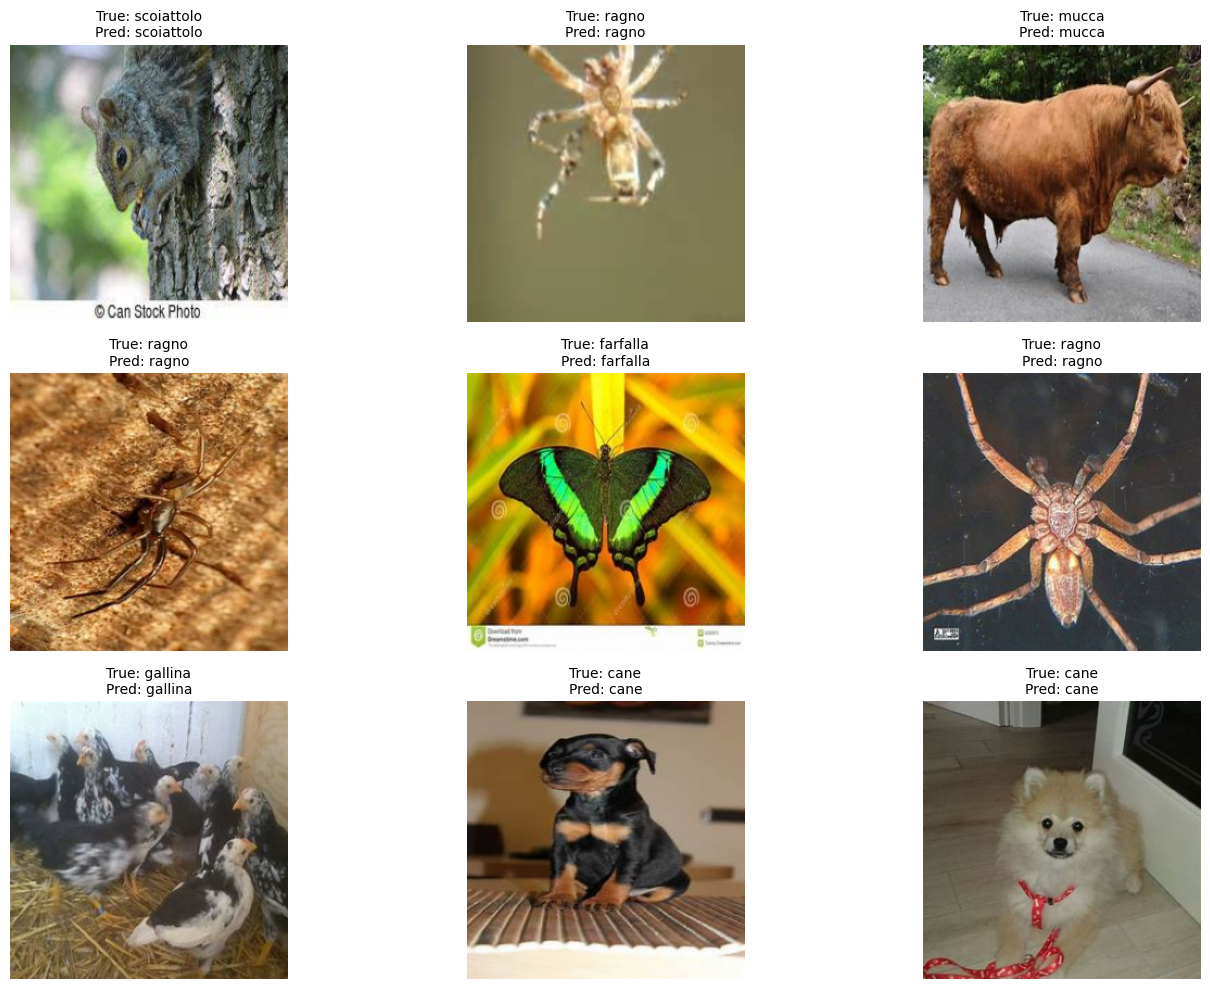

In [ ]:
vis_random_preds(model, test_loader, translated_classes, device, num_images=9)